In [1]:
import re
import pandas as pd
from os import listdir
from os.path import isfile, join

In [2]:
# preparing regular expressions for the desired columns

grant_id = re.compile('file\=\"([U][S]\w\w\d{6})\-\d{8}\.XML\"')
patent_title = re.compile("<invention-title id=\"\w{5,6}\">(.*?)</invention-title>") 
kind = re.compile("<kind>([A-Z]\d)</kind>")
number_of_claim = re.compile("\<number\-of\-claims\>(\d{1,4})\<\/number\-of\-claims\>")
first_name = re.compile("<first-name>(.*?)</first-name>")
last_name = re.compile("<last-name>(.*?)</last-name>")
citation_by_examiner = re.compile("\<category\>cited by examiner<\/category\>")
citation_by_applicant = re.compile("\<category>cited by applicant\<\/category\>")
claim_text = re.compile("<claim-text>[\s\S<]*</claim-text>")
abstract = re.compile("\<abstract id\=\"abstract\"\>\n\<p id\=\"p\-0001\" num\=\"0000\"\>(.*?)\<\/p\>\n\<\/abstract\>")

# cleaner for claim_text
cleaner = re.compile('<.*?>') 
cleaner2 = re.compile('\n')
cleaner3 = re.compile('\,\,\,')
cleaner4 = re.compile("[\.][\,][\,]")
cleaner5 = re.compile("[\,][\,]")
cleaner6 = re.compile("[\;][\,]")

In [3]:
mypath = './uspto'
paths = [mypath+'/'+f for f in listdir(mypath) if isfile(join(mypath, f))]
nbr_of_patents = []

df = pd.DataFrame(columns=['grant_id','patent_title','kind','number_of_claims','inventors',
                           'citations_applicant_count','citations_examiner_count','claims_text','abstract'])
for path in paths:
    print(path)
    file = open(file=path, mode='r') #opening the file in read mode
    file_content_raw = file.read()
    file.close()
    text1 = re.compile("<\?xml version=\"1\.0\" encoding\=\"UTF\-8\"\?>")
    file_content = text1.split(file_content_raw)
    while '' in file_content:
        file_content.remove('')
    print("No of patents :", len(file_content))
    nbr_of_patents.append(len(file_content))
    
    gid_list, title_list, kind_list, no_of_claim_list, name_list, applicant_list, examiners_list, claim_list, abstract_list, = ([] for i in range(9))

    for line in file_content:

        gid = grant_id.findall(line)
        title = patent_title.findall(line)
        kinds = kind.findall(line)
        sclaim = number_of_claim.findall(line)

        #looking for inventors
        inventors = re.findall("<inventor.*?>[\s\S]*</inventor>",line)
        for person in inventors:
            first = first_name.findall(person)
            last = last_name.findall(person)
        name = [firstName +" "+ lastName for firstName, lastName in zip(first,last)]
        if len(name) == 0:
            names = "NA"
        else:
            names = name

        #this code is to count number of citations by applicant
        if len(citation_by_applicant.findall(line)) == 0:
            citation_by_applicants = 0
        else:
            citation_by_applicants = len(citation_by_applicant.findall(line)) 

        # count for citation_by_examiner
        if len(citation_by_examiner.findall(line)) == 0:
            citation_by_examiners = 0
        else:    
            citation_by_examiners = len(citation_by_examiner.findall(line))   

        # Search for claim_text
        if (len(re.findall("<claim-text>[\s\S<]*</claim-text>",line)) == 0):
            claim_text = ["NA"]
        else:
            claim_text = re.findall("<claim-text>[\s\S<]*</claim-text>",line) 

        #Reading abstract
        abst = abstract.findall(line)
        if len(abst) == 0:
            abstracts = ["NA"]
        else:    
            abstracts = abst  
            
        if len(title) == 0:
            title = ["NA"]

        # check if there is more than one gid to append all the lists
        if len(gid) != 0:                             
            gid_list.append(gid[0])
            title_list.append(title[0])
            kind_list.append(kinds[0])
            no_of_claim_list.append(sclaim[0])
            name_list.append(names)
            applicant_list.append(citation_by_applicants)
            examiners_list.append(citation_by_examiners)
            claim_list.append(claim_text[0])
            abstract_list.append(abstracts[0])

    #Use cleaners for claim text         
    element = 0
    for items in claim_list:
        claim_list[element] = re.sub(cleaner,'',claim_list[element])
        claim_list[element] = re.sub(cleaner2,',',claim_list[element])
        claim_list[element] = re.sub(cleaner3,',',claim_list[element])
        claim_list[element] = re.sub(cleaner4,'.,',claim_list[element])
        claim_list[element] = re.sub(cleaner5,',',claim_list[element])
        claim_list[element] = re.sub(cleaner6,'; ',claim_list[element])
        element = element + 1

    # Replace abbreviation to get the kind 
    Kind1 = [w.replace('P2', 'Plant Patent Grant(with a published application) issued on or after January 2, 2001') for w in kind_list]
    Kind2 = [w.replace('B2', 'Utility Patent Grant (with a published application) issued on or after January 2, 2001.') for w in Kind1]
    Kind3 = [w.replace('S1', 'Design Patent') for w in Kind2]
    Kind4 = [w.replace('B1', 'Utility Patent Grant (no published application) issued on or after January 2, 2001.') for w in Kind3]

    # Get all results ad DataFrame
    data_frame = pd.DataFrame(
        {'grant_id': gid_list,
         'patent_title': title_list,
         'kind': Kind4,
         'number_of_claims':no_of_claim_list,
         'inventors':name_list,
         'citations_applicant_count':applicant_list,
         'citations_examiner_count':examiners_list,
         'claims_text':claim_list,
         'abstract':abstract_list
        })
    
    df = df.append(data_frame, ignore_index=True)

./uspto/ipg220830.xml
No of patents : 7394


/tmp/ipykernel_619143/1232607338.py:109: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_frame, ignore_index=True)


./uspto/ipg220913.xml
No of patents : 7453
./uspto/ipg220222.xml
No of patents : 7362
./uspto/ipg220802.xml
No of patents : 7416
./uspto/ipg220301.xml
No of patents : 7356
./uspto/ipg221004.xml
No of patents : 7426
./uspto/ipg220405.xml
No of patents : 7373
./uspto/ipg220712.xml
No of patents : 7414
./uspto/ipg220111.xml
No of patents : 5679
./uspto/ipg220322.xml
No of patents : 7352
./uspto/ipg220201.xml
No of patents : 7395
./uspto/ipg220118.xml
No of patents : 3569
./uspto/ipg220208.xml
No of patents : 5888
./uspto/ipg220426.xml
No of patents : 7336
./uspto/ipg220920.xml
No of patents : 7448
./uspto/ipg220927.xml
No of patents : 5921
./uspto/ipg220726.xml
No of patents : 4668
./uspto/ipg220614.xml
No of patents : 7463
./uspto/ipg220125.xml
No of patents : 5865
./uspto/ipg220628.xml
No of patents : 7436
./uspto/ipg220531.xml
No of patents : 7424
./uspto/ipg220705.xml
No of patents : 7411
./uspto/ipg220412.xml
No of patents : 7399
./uspto/ipg220621.xml
No of patents : 6013
./uspto/ipg

In [7]:
stats = pd.DataFrame({'date':[path.split('/')[-1].split('.')[0] for path in paths],'number of patents':nbr_of_patents})
stats.to_csv('./patents_per_week.csv')

In [8]:
df.to_csv('./uspto_df.csv')

In [9]:
len(df)

288878

# Dependency analysis between claims

Patents follow an inherent structure in they way they are structure.
- The fact that patent claims are always numbered can be used to tokenize claim text into separate claims
- Dependent claims usually refer to previous independent claims using certain terminologies (“ as in claim #")
- In the next step, we will create a custom "Claim Tokenizer" using a basic regular expression that captures the numbered nature of claims
> For this claim, I will be using the Regular expression that captures any number (digit) followed by a full-stop

In [10]:
import pandas as pd
import nltk
import re
import logging
#import stanfordcorenlp
import networkx as nx
import matplotlib.pyplot as plt
import pandas
import math
import numpy as np
import warnings

warnings.filterwarnings('ignore')



In [16]:
claim_text = df['claims_text'][2100]

In [17]:
# Use the NLTK package and insert custom regex to tokenize
from nltk.tokenize import RegexpTokenizer
s = claim_text
tokenizer = RegexpTokenizer('[0-9]\.', gaps=True)
patent1_tokenized_into_claims = tokenizer.tokenize(s)

# Convert list of claims into a dataframe
patent1_claims = pd.DataFrame({'Claims':patent1_tokenized_into_claims})
patent1_claims['Claim_ID'] = patent1_claims.index + 1
print(patent1_claims)

# Using the regex to get claim number
patent1_claims['Parent_claim_desc'] = patent1_claims['Claims'].str.extract('(claim \d\d*)', expand=True)

# Getting the numerical value of the claim number
patent1_claims['Parent_claim_num'] = patent1_claims['Parent_claim_desc'].str.extract('(\d\d*)', expand=True)

# Defining Claim node 
patent1_claims['Claim_node'] = patent1_claims['Claim_ID']

# Defining Parent node (If independent claim, Parent node = claim node)
patent1_claims['Parent_claim_num']=patent1_claims['Parent_claim_num'].fillna(0)

# Converted string mined using regex to a numerical value
for i in range(len(patent1_claims['Parent_claim_num'])):
    patent1_claims['Parent_claim_num'][i] = int(patent1_claims['Parent_claim_num'][i])
patent1_claims.loc[ patent1_claims.Parent_claim_num == 0, 'Parent_node' ] = patent1_claims.Claim_node
patent1_claims.loc[ patent1_claims.Parent_claim_num != 0, 'Parent_node' ] = patent1_claims.Parent_claim_num


                                               Claims  Claim_ID
0    A hydraulic system for controlling a left cas...         1
1    The hydraulic system set forth in claim 1, wh...         2
2    The hydraulic system set forth in claim 1, wh...         3
3    The hydraulic system set forth in claim 3, wh...         4
4    The hydraulic system set forth in claim 1, wh...         5
5    The hydraulic system set forth in claim 1, wh...         6
6    The hydraulic system set forth in claim 6, fu...         7
7    The hydraulic system set forth in claim 7, wh...         8
8    The hydraulic system set forth in claim 7, fu...         9
9    The hydraulic system set forth in claim 1, wh...        10
10   The hydraulic system set forth in claim 10, f...        11
11   The hydraulic system set forth in claim 11, f...        12
12   The hydraulic system set forth in claim 1, wh...        13
13   The hydraulic system set forth in claim 13, w...        14
14   A hydraulic system for controlling 

In [27]:
patent1_claims.drop(index=[0],axis=0,inplace=True)

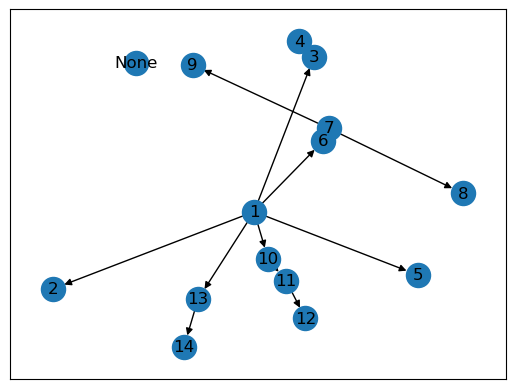

ok


NameError: name 'graphviz_layout' is not defined

In [28]:
#Build the graph
G=nx.DiGraph()   
G.add_nodes_from(patent1_claims.Parent_node)
G.nodes()
G.add_node('None')

#Add edges
subset = patent1_claims[['Parent_node','Claim_node']]
tuples = [tuple(x) for x in subset.values] 
G.add_edges_from(tuples)
G.number_of_edges()

#Perform Graph Drawing
#A star network  (sort of)
nx.draw_networkx(G)
plt.show()
t = input()
#A tree network (sort of)
nx.draw(G, pos=graphviz_layout(G), node_size=1600, cmap=plt.cm.Blues,node_color=range(len(G)), prog='dot', splines=ortho)
plt.show()

- Dependency parsing with StanfordCoreNlp

In [50]:
from stanfordcorenlp import StanfordCoreNLP

nlp = StanfordCoreNLP(r'D:\Desktop\Patent segmentation/stanford-corenlp-4.5.0')

sentence = patent1_claims.iloc[1, 0]
print ('Part of Speech:', nlp.pos_tag(sentence))
print ('Constituency Parsing:', nlp.parse(sentence))
print ('Dependency Parsing:', nlp.dependency_parse(sentence))

nlp.close() 

Part of Speech: [('The', 'DT'), ('power', 'NN'), ('conversion', 'NN'), ('device', 'NN'), ('according', 'VBG'), ('to', 'IN'), ('claim', 'NN'), ('1', 'CD'), (',', ','), ('wherein', 'WRB'), ('a', 'DT'), ('rib', 'NN'), ('is', 'VBZ'), ('integrally', 'RB'), ('provided', 'VBN'), ('with', 'IN'), ('the', 'DT'), ('second', 'JJ'), ('wall', 'NN'), ('portion', 'NN'), ('and', 'CC'), ('the', 'DT'), ('peripheral', 'JJ'), ('wall', 'NN'), ('portion.', 'NN'), (',', ',')]
Constituency Parsing: (ROOT
  (S
    (NP (DT The) (NN power))
    (VP
      (FRAG
        (NP (NN conversion) (NN device))
        (PP (VBG according)
          (PP (IN to)
            (NP
              (NP (NN claim) (CD 1))
              (, ,)
              (SBAR
                (WHADVP (WRB wherein))
                (S
                  (NP (DT a) (NN rib))
                  (VP (VBZ is)
                    (ADVP (RB integrally))
                    (VP (VBN provided)
                      (PP (IN with)
                        (NP
   